In [86]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from math import sqrt

# Criar diretório para os gráficos
output_dir = "graficos_python"
os.makedirs(output_dir, exist_ok=True)

# Dados
acuracia = [0.94, 0.96, 0.9068, 0.891, 0.773, 0.9471, 0.728, 0.875, 0.99139, 0.852, 0.96, 0.9512, 0.9876]
sens = [0.94, 0.9635, 0.907, 0.939, 0.762, 0.897, 0.728, 0.87, 0.9838, 0.821, 0.94, 0.9512, 0.978]
prec = [0.94, 0.9887, 0.9067, 0.951, 0.913, 0.7705, 0.738, 0.89, 0.9568, 0.834, 0.95, 0.9525, 0.988]
fscore = [0.94, 0.9655, 0.9063, 0.945, 0.830693731, 0.828951724, 0.732, 0.88, 0.9929, 0.827, 0.94, 0.9518, 0.982]

se_acuracia = [0.001876865, 0.061636994, 0.025207971, 0.00906449, 0.03645992, 0.009137978, 0.014376971, 0.042695628, 0.002426274, 0.0057696, 0.037712362, 0.011516269, 0.014787929]
se_sens = [0.001876865, 0.056542623, 0.025183686, 0.006961278, 0.03706628, 0.012409069, 0.014376971, 0.043416587, 0.003315331, 0.006228638, 0.045704364, 0.011516269, 0.019601385]
se_prec = [0.001876865, 0.031869492, 0.0252201, 0.006278842, 0.024530593, 0.017167302, 0.014206794, 0.040393894, 0.005339105, 0.006045498, 0.041943525, 0.011369602, 0.014550405]
se_fscore = [0.001876865, 0.055028712, 0.025268529, 0.006631145, 0.032641493, 0.015372636, 0.014310018, 0.041952354, 0.002204946, 0.006145692, 0.045704364, 0.011448863, 0.017766341]

doenca = [
    "Câncer de pele", "Lesão Vertebral", "Múltiplas", "Malária", "Doença Arterial Coronariana (CAD)",
    "Câncer de pele", "Doença Arterial Coronariana (CAD)", "Múltiplas", "Câncer de mama",
    "Doença Arterial Coronariana (CAD)", "Múltiplas", "Periodontal", "Câncer"
]

key = [
    "CNN", "PSO + AdaBoost", "CNN", "CNN", "Random Forest (RF)",
    "CNN", "XGBoost", "CNN", "Logistic Regression (LR)", "XGBoost", "CNN", "CNN", "TF"
]

id = list(range(1, 14))

# Criar DataFrames com índice sequencial
def criar_dataframe(metrica, se, nome_metrica):
    return pd.DataFrame({
        'id': id,
        'est': metrica,
        'se': se,
        'tecnica': key,
        'doenca': doenca,
        'label': [f"A {id[i]} - {key[i]}" for i in range(len(id))]
    })

dados_acuracia = criar_dataframe(acuracia, se_acuracia, 'acuracia')
# Ordenar pelo valor da métrica (opcional)
dados_acuracia = dados_acuracia.sort_values(by='est')

dados_sens = criar_dataframe(sens, se_sens, 'sensibilidade')
# Ordenar pelo valor da métrica (opcional)
dados_sens = dados_sens.sort_values(by='est')

dados_prec = criar_dataframe(prec, se_prec, 'precisao')
# Ordenar pelo valor da métrica (opcional)
dados_prec = dados_prec.sort_values(by='est')

dados_fscore = criar_dataframe(fscore, se_fscore, 'fscore')
# Ordenar pelo valor da métrica (opcional)
dados_fscore = dados_fscore.sort_values(by='est')

# Função para calcular o tau² (efeito aleatório)
def calcular_tau2_dl(eff, var_eff):
    k = len(eff)
    if k <= 1:
        return 0
    weights_fixed = 1.0 / var_eff
    mean_eff_fixed = np.sum(weights_fixed * eff) / np.sum(weights_fixed)
    Q = np.sum(weights_fixed * (eff - mean_eff_fixed)**2)
    C = np.sum(weights_fixed) - np.sum(weights_fixed**2) / np.sum(weights_fixed)
    tau2 = max(0, (Q - (k - 1)) / C)
    return tau2

# Meta-análise aleatória DerSimonian-Laird
def realizar_metaanalise_aleatoria_dl(dados):
    estimativas = dados['est'].values
    variancias = (dados['se'].values)**2
    tau2 = calcular_tau2_dl(estimativas, variancias)
    variancia_total = variancias + tau2
    pesos_aleatorios = 1.0 / variancia_total
    efeito_combinado = np.sum(pesos_aleatorios * estimativas) / np.sum(pesos_aleatorios)
    variancia_combinada = 1.0 / np.sum(pesos_aleatorios)
    erro_padrao_combinado = sqrt(variancia_combinada)
    intervalo_confianca = (efeito_combinado - 1.96 * erro_padrao_combinado,
                           efeito_combinado + 1.96 * erro_padrao_combinado)
    return efeito_combinado, erro_padrao_combinado, intervalo_confianca, tau2

# Função para gerar gráfico de floresta com novos labels
def gerar_grafico_floresta(dados, efeito_combinado, erro_padrao_combinado, ic_combinado, tau2, titulo, filename):
    estimativas = dados['est'].values
    erros_padrao = dados['se'].values
    labels = dados['label'].values
    n_estudos = len(estimativas)
    y_pos = np.arange(n_estudos)

    fig, ax = plt.subplots(figsize=(10, n_estudos // 2 + 3))
    ax.errorbar(estimativas, y_pos, xerr=1.96 * erros_padrao, fmt='o', color='black', capsize=5)
    ax.scatter(estimativas, y_pos, color='blue', s=50)
    ax.axvline(efeito_combinado, color='red', linestyle='--', linewidth=2,
               label=f'Efeito Combinado (DL): {efeito_combinado:.4f} (IC 95%: [{ic_combinado[0]:.4f}, {ic_combinado[1]:.4f}]), τ² = {tau2:.4f}')
    ax.fill_betweenx([-1, n_estudos], ic_combinado[0], ic_combinado[1], color='lightcoral', alpha=0.2)

    ax.set_yticks(y_pos)
    ax.set_yticklabels(labels)
    ax.invert_yaxis()
    ax.set_xlabel('Estimativa')
    ax.set_title(titulo)
    ax.legend(loc='lower left')
    ax.grid(axis='x', linestyle='--')
    plt.tight_layout()

    # Salva como PNG
    path = os.path.join(output_dir, filename)
    plt.savefig(path, dpi=300, bbox_inches='tight')
    plt.close()

# Análise completa para cada métrica
def analisar_metrica(dados, nome_metrica):
    efeito_combinado, erro_padrao_combinado, ic_combinado, tau2 = realizar_metaanalise_aleatoria_dl(dados)
    gerar_grafico_floresta(dados, efeito_combinado, erro_padrao_combinado, ic_combinado, tau2,
                           f'Gráfico de Floresta - {nome_metrica.capitalize()}', f'{nome_metrica}.png')

# Executando análise
analisar_metrica(dados_acuracia, 'acuracia')
analisar_metrica(dados_sens, 'sensibilidade')
analisar_metrica(dados_prec, 'precisao')
analisar_metrica(dados_fscore, 'fscore')

# Análise por subgrupo: doença
def analisar_subgrupo(dados, nome_metrica):
    for doenca_nome, grupo in dados.groupby('doenca'):
        grupo = grupo.reset_index(drop=True)
        #grupo['label'] = [f"A{i+1} - {grupo['tecnica'][i]}" for i in range(len(grupo))]
        
        efeito_combinado, erro_padrao_combinado, ic_combinado, tau2 = realizar_metaanalise_aleatoria_dl(grupo)
        
        filename = f"{nome_metrica}_subgrupo_{doenca_nome.replace(' ', '_').replace('(', '').replace(')', '')}.png"
        gerar_grafico_floresta(grupo, efeito_combinado, erro_padrao_combinado, ic_combinado, tau2,
                               f'Gráfico de Floresta - {nome_metrica.capitalize()} ({doenca_nome})',
                               filename)

# Executar análise por subgrupo
analisar_subgrupo(dados_acuracia, 'acuracia')
analisar_subgrupo(dados_sens, 'sensibilidade')
analisar_subgrupo(dados_prec, 'precisao')
analisar_subgrupo(dados_fscore, 'fscore')

# Análise por subgrupo: técnica
def analisar_subgrupo_tecnica(dados, nome_metrica):
    for tecnica_nome, grupo in dados.groupby('tecnica'):
        grupo = grupo.reset_index(drop=True)
        #grupo['label'] = [f"A{i+1} - {grupo['doenca'][i]}" for i in range(len(grupo))]

        efeito_combinado, erro_padrao_combinado, ic_combinado, tau2 = realizar_metaanalise_aleatoria_dl(grupo)

        filename = f"{nome_metrica}_subgrupo_tecnica_{tecnica_nome.replace(' ', '_')}.png"
        gerar_grafico_floresta(grupo, efeito_combinado, erro_padrao_combinado, ic_combinado, tau2,
                               f'Gráfico de Floresta - {nome_metrica.capitalize()} (Técnica: {tecnica_nome})',
                               filename)

# Executar análise por subgrupo de técnica
analisar_subgrupo_tecnica(dados_acuracia, 'acuracia')
analisar_subgrupo_tecnica(dados_sens, 'sensibilidade')
analisar_subgrupo_tecnica(dados_prec, 'precisao')
analisar_subgrupo_tecnica(dados_fscore, 'fscore')



In [87]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

# Dados
acuracia = [0.94, 0.96, 0.9068, 0.891, 0.773, 0.9471, 0.728, 0.875, 0.99139, 0.852, 0.96, 0.9512, 0.9876]
sens = [0.94, 0.9635, 0.907, 0.939, 0.762, 0.897, 0.728, 0.87, 0.9838, 0.821, 0.94, 0.9512, 0.978]
prec = [0.94, 0.9887, 0.9067, 0.951, 0.913, 0.7705, 0.738, 0.89, 0.9568, 0.834, 0.95, 0.9525, 0.988]
fscore = [0.94, 0.9655, 0.9063, 0.945, 0.830693731, 0.828951724, 0.732, 0.88, 0.9929, 0.827, 0.94, 0.9518, 0.982]

se_acuracia = [0.001876865, 0.061636994, 0.025207971, 0.00906449, 0.03645992, 0.009137978, 0.014376971, 0.042695628, 0.002426274, 0.0057696, 0.037712362, 0.011516269, 0.014787929]
se_sens = [0.001876865, 0.056542623, 0.025183686, 0.006961278, 0.03706628, 0.012409069, 0.014376971, 0.043416587, 0.003315331, 0.006228638, 0.045704364, 0.011516269, 0.019601385]
se_prec = [0.001876865, 0.031869492, 0.0252201, 0.006278842, 0.024530593, 0.017167302, 0.014206794, 0.040393894, 0.005339105, 0.006045498, 0.041943525, 0.011369602, 0.014550405]
se_fscore = [0.001876865, 0.055028712, 0.025268529, 0.006631145, 0.032641493, 0.015372636, 0.014310018, 0.041952354, 0.002204946, 0.006145692, 0.045704364, 0.011448863, 0.017766341]

n = [15007, 11, 133, 1182, 132, 600, 958, 60, 1450, 3788, 27, 350, 56]

# Criar DataFrame
df = pd.DataFrame({
    'N': n,
    'Accuracy': acuracia,
    'SE_Accuracy': se_acuracia,
    'F1_score': fscore,
    'SE_F1_score': se_fscore,
    'Precision': prec,
    'SE_Precision': se_prec,
    'Recall': sens,
    'SE_Recall': se_sens,
})

# Função de Meta-Regressão com gráfico de dispersão + linha de regressão
def meta_regressao_DL(df, metric, se_metric, output_dir):
    df = df.copy()
    df['Vi'] = df[se_metric] ** 2
    df['Wi'] = 1 / df['Vi']

    fixed_effect = np.sum(df['Wi'] * df[metric]) / np.sum(df['Wi'])
    Q = np.sum(df['Wi'] * (df[metric] - fixed_effect) ** 2)
    C = np.sum(df['Wi']) - (np.sum(df['Wi']**2) / np.sum(df['Wi']))
    tau2 = max(0, (Q - (len(df) - 1)) / C)

    df['Wi_RE'] = 1 / (df['Vi'] + tau2)

    # Regressão ponderada com intercepto e N
    X = df[['N']]
    X = np.hstack([np.ones((X.shape[0], 1)), X])  # intercepto
    Y = df[metric].values
    W = np.diag(df['Wi_RE'].values)

    beta = np.linalg.inv(X.T @ W @ X) @ (X.T @ W @ Y)

    # Gráfico de dispersão com linha de regressão
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.scatter(df['N'], df[metric], s=60, color='skyblue', edgecolor='black', label='Estudos')

    # Linha de regressão
    x_vals = np.linspace(min(df['N']), max(df['N']), 100)
    y_vals = beta[0] + beta[1] * x_vals
    #ax.plot(x_vals, y_vals, color='darkblue', label='Linha de Regressão')

    ax.set_xlabel('Tamanho da Amostra (N)')
    ax.set_ylabel(f'{metric}')
    #ax.set_title(f'Meta-Regressão: {metric} vs. Tamanho da Amostra (Modelo DerSimonian-Laird)')
    ax.legend()
    plt.tight_layout()

    os.makedirs(output_dir, exist_ok=True)
    filename = os.path.join(output_dir, f'meta_regressao_scatter_{metric}.png')
    plt.savefig(filename, dpi=300)
    plt.close()
    print(f"[✔] Gráfico salvo: {filename}")

# Dicionário de métricas e erros padrão
metricas = {
    'Accuracy': 'SE_Accuracy',
    'F1_score': 'SE_F1_score',
    'Precision': 'SE_Precision',
    'Recall': 'SE_Recall'
}

# Pasta de saída
output_dir = 'resultados_plots_scatter_quantidade_amostras_desempenho_metrica'

# Gerar gráficos
for metrica, se in metricas.items():
    meta_regressao_DL(df, metrica, se, output_dir)


[✔] Gráfico salvo: resultados_plots_scatter_quantidade_amostras_desempenho_metrica\meta_regressao_scatter_Accuracy.png
[✔] Gráfico salvo: resultados_plots_scatter_quantidade_amostras_desempenho_metrica\meta_regressao_scatter_F1_score.png
[✔] Gráfico salvo: resultados_plots_scatter_quantidade_amostras_desempenho_metrica\meta_regressao_scatter_Precision.png
[✔] Gráfico salvo: resultados_plots_scatter_quantidade_amostras_desempenho_metrica\meta_regressao_scatter_Recall.png


In [ ]:
#Daqui para baixo -- Efeito Estimado considerando Técnica 

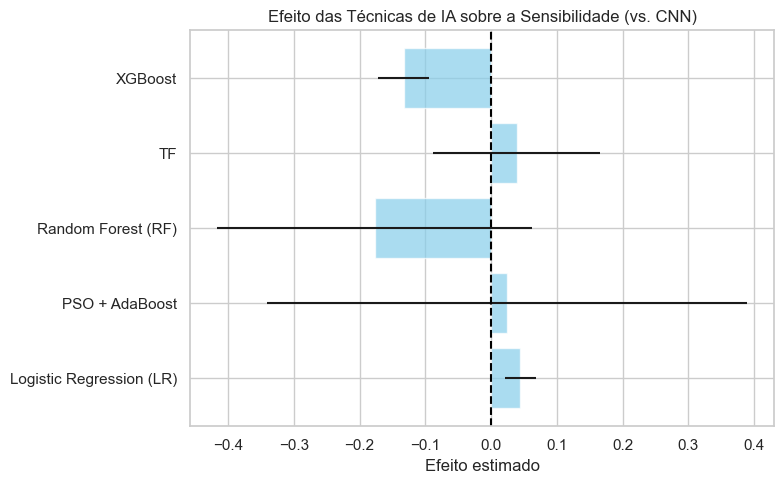


 Tabela resumo - Efeito das técnicas sobre a Sensibilidade (vs. CNN):
                 Técnica  Efeito Estimado  IC 95% Inferior  IC 95% Superior  p-valor
Logistic Regression (LR)           0.0447           0.0205           0.0690   0.0033
          PSO + AdaBoost           0.0244          -0.3410           0.3899   0.8788
      Random Forest (RF)          -0.1771          -0.4167           0.0626   0.1242
                      TF           0.0389          -0.0882           0.1661   0.4923
                 XGBoost          -0.1327          -0.1714          -0.0941   0.0001
[✔] Tabela resumo salva em: resultados_plots_efeitos_estimados_tecnica\resumo_sensibilidade_vs_cnn.csv
[✔] Gráfico salvo: resultados_plots_efeitos_estimados_tecnica\sensibilidade_vs_cnn.png


In [100]:
#1 - Sensibilidade

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm

# Pasta de saída
output_dir = 'resultados_plots_efeitos_estimados_tecnica'

# Dados fornecidos
doenca = [
    "Câncer de pele", "Lesão Vertebral", "Múltiplas", "Malária", "Doença Arterial Coronariana (CAD)",
    "Câncer de pele", "Doença Arterial Coronariana (CAD)", "Múltiplas", "Câncer de mama",
    "Doença Arterial Coronariana (CAD)", "Múltiplas", "Periodontal", "Câncer"
]

key = [
    "CNN", "PSO + AdaBoost", "CNN", "CNN", "Random Forest (RF)", "CNN", "XGBoost", "CNN",
    "Logistic Regression (LR)", "XGBoost", "CNN", "CNN", "TF"
]

# Sensibilidade e erro padrão (substitua com seus dados reais se necessário)
sens = [0.94, 0.9635, 0.907, 0.939, 0.762, 0.897, 0.728, 0.87, 0.9838, 0.821, 0.94, 0.9512, 0.978]
se_sens = [0.001876865, 0.056542623, 0.025183686, 0.006961278, 0.03706628, 0.012409069, 0.014376971, 0.043416587, 0.003315331, 0.006228638, 0.045704364, 0.011516269, 0.019601385]

# Criar DataFrame
df = pd.DataFrame({
    'sens': sens,
    'se': se_sens,
    'tecnica': key,
    'doenca': doenca
})

# Codificar a variável técnica (CNN como referência)
df['tecnica_cod'] = pd.Categorical(df['tecnica'])
df['tecnica_cod'] = df['tecnica_cod'].cat.reorder_categories(['CNN'] + sorted(set(key) - {'CNN'}))
X = pd.get_dummies(df['tecnica_cod'], drop_first=True).astype(float)  # Garantir tipo float
X = sm.add_constant(X).astype(float)  # Também garantir float aqui

y = df['sens'].astype(float)
w = 1 / (df['se'].astype(float) ** 2)

# Meta-regressão (ponderada)
model = sm.WLS(y, X, weights=w).fit()
efeitos = model.params[1:]
ic = model.conf_int().iloc[1:]

# Plot do forest plot
tecnicas = efeitos.index
y_pos = np.arange(len(tecnicas))

plt.figure(figsize=(8, 5))
plt.barh(y_pos, efeitos.values, xerr=(ic[1] - efeitos).values, color='skyblue', alpha=0.7)
plt.axvline(0, color='black', linestyle='--')
plt.yticks(y_pos, tecnicas)
plt.xlabel('Efeito estimado')
plt.title('Efeito das Técnicas de IA sobre a Sensibilidade (vs. CNN)')
plt.tight_layout()
os.makedirs(output_dir, exist_ok=True)
filename = os.path.join(output_dir, f'sensibilidade_vs_cnn.png')
plt.savefig(filename, dpi=300)
plt.show()
plt.close()

# Gerar tabela resumo com efeitos estimados, IC 95% e p-valores
summary_df = pd.DataFrame({
    'Técnica': efeitos.index,
    'Efeito Estimado': efeitos.values,
    'IC 95% Inferior': ic[0].values,
    'IC 95% Superior': ic[1].values,
    'p-valor': model.pvalues[1:].values
})

# Exibir e salvar a tabela
print("\n Tabela resumo - Efeito das técnicas sobre a Sensibilidade (vs. CNN):")
print(summary_df.to_string(index=False, float_format="%.4f"))

# Salvar como CSV
tabela_filename = os.path.join(output_dir, 'resumo_sensibilidade_vs_cnn.csv')
summary_df.to_csv(tabela_filename, index=False)

print(f"[✔] Tabela resumo salva em: {tabela_filename}")
print(f"[✔] Gráfico salvo: {filename}")


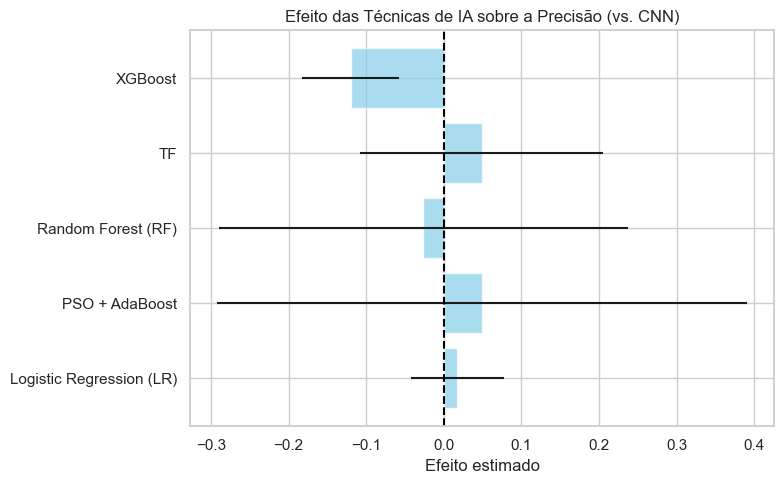


 Tabela resumo - Efeito das técnicas sobre a Precisão (vs. CNN):
                 Técnica  Efeito Estimado  IC 95% Inferior  IC 95% Superior  p-valor
Logistic Regression (LR)           0.0177          -0.0425           0.0778   0.5102
          PSO + AdaBoost           0.0496          -0.2922           0.3913   0.7417
      Random Forest (RF)          -0.0261          -0.2895           0.2372   0.8211
                      TF           0.0489          -0.1081           0.2058   0.4855
                 XGBoost          -0.1199          -0.1823          -0.0574   0.0027
[✔] Tabela resumo salva em: resultados_plots_efeitos_estimados_tecnica\resumo_precisao_vs_cnn.csv
[✔] Gráfico salvo: resultados_plots_efeitos_estimados_tecnica\precisao_vs_cnn.png


In [98]:
#2 - Precisão

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm

# Pasta de saída
output_dir = 'resultados_plots_efeitos_estimados_tecnica'

# Dados fornecidos
doenca = [
    "Câncer de pele", "Lesão Vertebral", "Múltiplas", "Malária", "Doença Arterial Coronariana (CAD)",
    "Câncer de pele", "Doença Arterial Coronariana (CAD)", "Múltiplas", "Câncer de mama",
    "Doença Arterial Coronariana (CAD)", "Múltiplas", "Periodontal", "Câncer"
]

key = [
    "CNN", "PSO + AdaBoost", "CNN", "CNN", "Random Forest (RF)", "CNN", "XGBoost", "CNN",
    "Logistic Regression (LR)", "XGBoost", "CNN", "CNN", "TF"
]

# Precisão e erro padrão
prec = [0.94, 0.9887, 0.9067, 0.951, 0.913, 0.7705, 0.738, 0.89, 0.9568, 0.834, 0.95, 0.9525, 0.988]
se_prec = [0.001876865, 0.031869492, 0.0252201, 0.006278842, 0.024530593, 0.017167302, 0.014206794, 0.040393894, 0.005339105, 0.006045498, 0.041943525, 0.011369602, 0.014550405]

# Criar DataFrame
df = pd.DataFrame({
    'prec': prec,
    'se_prec': se_prec,
    'tecnica': key,
    'doenca': doenca
})

# Codificar a variável técnica (CNN como referência)
df['tecnica_cod'] = pd.Categorical(df['tecnica'])
df['tecnica_cod'] = df['tecnica_cod'].cat.reorder_categories(['CNN'] + sorted(set(key) - {'CNN'}))
X = pd.get_dummies(df['tecnica_cod'], drop_first=True).astype(float)  # Garantir tipo float
X = sm.add_constant(X).astype(float)  # Também garantir float aqui

y = df['prec'].astype(float)
w = 1 / (df['se_prec'].astype(float) ** 2)

# Meta-regressão (ponderada)
model = sm.WLS(y, X, weights=w).fit()
efeitos = model.params[1:]
ic = model.conf_int().iloc[1:]

# Plot do forest plot
tecnicas = efeitos.index
y_pos = np.arange(len(tecnicas))

plt.figure(figsize=(8, 5))
plt.barh(y_pos, efeitos.values, xerr=(ic[1] - efeitos).values, color='skyblue', alpha=0.7)
plt.axvline(0, color='black', linestyle='--')
plt.yticks(y_pos, tecnicas)
plt.xlabel('Efeito estimado')
plt.title('Efeito das Técnicas de IA sobre a Precisão (vs. CNN)')
plt.tight_layout()
os.makedirs(output_dir, exist_ok=True)
filename = os.path.join(output_dir, f'precisao_vs_cnn.png')
plt.savefig(filename, dpi=300)
plt.show()
plt.close()

# Gerar tabela resumo com efeitos estimados, IC 95% e p-valores
summary_df = pd.DataFrame({
    'Técnica': efeitos.index,
    'Efeito Estimado': efeitos.values,
    'IC 95% Inferior': ic[0].values,
    'IC 95% Superior': ic[1].values,
    'p-valor': model.pvalues[1:].values
})

# Exibir e salvar a tabela
print("\n Tabela resumo - Efeito das técnicas sobre a Precisão (vs. CNN):")
print(summary_df.to_string(index=False, float_format="%.4f"))

# Salvar como CSV
tabela_filename = os.path.join(output_dir, 'resumo_precisao_vs_cnn.csv')
summary_df.to_csv(tabela_filename, index=False)

print(f"[✔] Tabela resumo salva em: {tabela_filename}")
print(f"[✔] Gráfico salvo: {filename}")

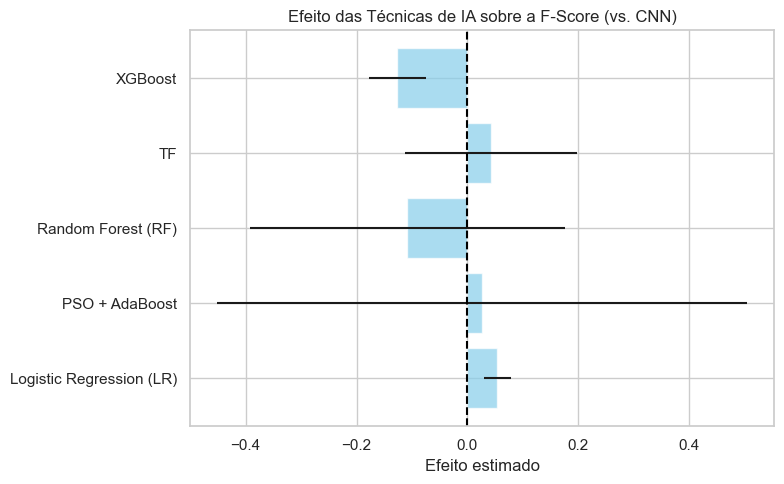


 Tabela resumo - Efeito das técnicas sobre o F-Score (vs. CNN):
                 Técnica  Efeito Estimado  IC 95% Inferior  IC 95% Superior  p-valor
Logistic Regression (LR)           0.0540           0.0295           0.0785   0.0012
          PSO + AdaBoost           0.0266          -0.4516           0.5048   0.8991
      Random Forest (RF)          -0.1082          -0.3922           0.1757   0.3975
                      TF           0.0431          -0.1120           0.1982   0.5321
                 XGBoost          -0.1267          -0.1781          -0.0753   0.0006
[✔] Tabela resumo salva em: resultados_plots_efeitos_estimados_tecnica\resumo_fscore_vs_cnn.csv
[✔] Gráfico salvo: resultados_plots_efeitos_estimados_tecnica\fscore_vs_cnn.png


In [99]:
#3 - F-Score

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm

# Pasta de saída
output_dir = 'resultados_plots_efeitos_estimados_tecnica'

# Dados fornecidos
doenca = [
    "Câncer de pele", "Lesão Vertebral", "Múltiplas", "Malária", "Doença Arterial Coronariana (CAD)",
    "Câncer de pele", "Doença Arterial Coronariana (CAD)", "Múltiplas", "Câncer de mama",
    "Doença Arterial Coronariana (CAD)", "Múltiplas", "Periodontal", "Câncer"
]

key = [
    "CNN", "PSO + AdaBoost", "CNN", "CNN", "Random Forest (RF)", "CNN", "XGBoost", "CNN",
    "Logistic Regression (LR)", "XGBoost", "CNN", "CNN", "TF"
]

# F-Score e erro padrão
fscore = [0.94, 0.9655, 0.9063, 0.945, 0.830693731, 0.828951724, 0.732, 0.88, 0.9929, 0.827, 0.94, 0.9518, 0.982]
se_fscore = [0.001876865, 0.055028712, 0.025268529, 0.006631145, 0.032641493, 0.015372636, 0.014310018, 0.041952354, 0.002204946, 0.006145692, 0.045704364, 0.011448863, 0.017766341]

# Criar DataFrame
df = pd.DataFrame({
    'fscore': fscore,
    'se_fscore': se_fscore,
    'tecnica': key,
    'doenca': doenca
})

# Codificar a variável técnica (CNN como referência)
df['tecnica_cod'] = pd.Categorical(df['tecnica'])
df['tecnica_cod'] = df['tecnica_cod'].cat.reorder_categories(['CNN'] + sorted(set(key) - {'CNN'}))
X = pd.get_dummies(df['tecnica_cod'], drop_first=True).astype(float)  # Garantir tipo float
X = sm.add_constant(X).astype(float)  # Também garantir float aqui

y = df['fscore'].astype(float)
w = 1 / (df['se_fscore'].astype(float) ** 2)

# Meta-regressão (ponderada)
model = sm.WLS(y, X, weights=w).fit()
efeitos = model.params[1:]
ic = model.conf_int().iloc[1:]

# Plot do forest plot
tecnicas = efeitos.index
y_pos = np.arange(len(tecnicas))

plt.figure(figsize=(8, 5))
plt.barh(y_pos, efeitos.values, xerr=(ic[1] - efeitos).values, color='skyblue', alpha=0.7)
plt.axvline(0, color='black', linestyle='--')
plt.yticks(y_pos, tecnicas)
plt.xlabel('Efeito estimado')
plt.title('Efeito das Técnicas de IA sobre a F-Score (vs. CNN)')
plt.tight_layout()
os.makedirs(output_dir, exist_ok=True)
filename = os.path.join(output_dir, f'fscore_vs_cnn.png')
plt.savefig(filename, dpi=300)
plt.show()
plt.close()

# Gerar tabela resumo com efeitos estimados, IC 95% e p-valores
summary_df = pd.DataFrame({
    'Técnica': efeitos.index,
    'Efeito Estimado': efeitos.values,
    'IC 95% Inferior': ic[0].values,
    'IC 95% Superior': ic[1].values,
    'p-valor': model.pvalues[1:].values
})

# Exibir e salvar a tabela
print("\n Tabela resumo - Efeito das técnicas sobre o F-Score (vs. CNN):")
print(summary_df.to_string(index=False, float_format="%.4f"))

# Salvar como CSV
tabela_filename = os.path.join(output_dir, 'resumo_fscore_vs_cnn.csv')
summary_df.to_csv(tabela_filename, index=False)

print(f"[✔] Tabela resumo salva em: {tabela_filename}")
print(f"[✔] Gráfico salvo: {filename}")